# 1. Setup

In [1]:
import networkx as nx
import os
import numpy as np
import math
import torch
from torch import nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from scipy.stats import kendalltau

C:\Users\caleb\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data Preprocessing  
Data Structure:
1. **gList** <Dict>: containing total 31 graphs, which 30 from Synthetic and 1 from youtube,using filename as key  
2. element of gList <Dict>: 'graph':nx.Graph();'score': <Dict> with 'node' and 'score'

In [67]:
# Input data
dpath = ".\\data\\"
gList = dict()
filenames = []

for root, dirs, files in os.walk(dpath):
    for file in files:
        file_path = os.path.join(root, file)
        if 'score' not in file:
            filenames.append(file)
            # Process nodes and edges
            gList[file] = dict()
            gList[file]['graph']=nx.Graph()
            with open(file_path,'r') as f:
                content = f.readlines()
                edges = []
                for line in content:
                    if 'com' not in file:
                        nodes = line[:-1].split('\t')
                    else:
                        #continue # after finish all code run code with com
                        nodes = line[:-1].split(" ")
                    # Create edge tuple and append
                    edges.append((int(nodes[0]),int(nodes[1])))
                gList[file]['graph'].add_edges_from(edges)
                if 'com' not in file:
                    avg_deg = np.mean(list(dict(sorted(dict(gList[file]['graph'].degree()).items())).values()))
                    diameter = nx.diameter(gList[file]['graph'])
                    print("{} has {} nodes, {} edges, avg. degree = {}, diameter = {}".format(file,gList[file]['graph'].number_of_nodes(),gList[file]['graph'].number_of_edges(),avg_deg,diameter))
                else:
                    print("{} has {} nodes, {} edges".format(file,gList[file]['graph'].number_of_nodes(),gList[file]['graph'].number_of_edges()))
            
            # Process scores
            scorefile = file.replace(".txt","_score.txt")
            gList[file]['score'] = dict()
            score_file_path = os.path.join(root,scorefile) 
            with open(score_file_path,'r') as f:
                content = f.readlines()
                for line in content:
                    if 'com' not in file:
                        node_score = line[:-1].split('\t')
                        gList[file]['score'][int(node_score[0])] = float(node_score[1])
                    else:
                        #continue # after finish all code run code with com
                        node_score = line[:-1].split()
                        gList[file]['score'][int(node_score[0][:-1])] = float(node_score[1])

0.txt has 5000 nodes, 19982 edges, avg. degree = 7.9928, diameter = 6
1.txt has 5000 nodes, 19981 edges, avg. degree = 7.9924, diameter = 6
10.txt has 5000 nodes, 19980 edges, avg. degree = 7.992, diameter = 6
11.txt has 5000 nodes, 19983 edges, avg. degree = 7.9932, diameter = 6
12.txt has 5000 nodes, 19983 edges, avg. degree = 7.9932, diameter = 6
13.txt has 5000 nodes, 19984 edges, avg. degree = 7.9936, diameter = 6
14.txt has 5000 nodes, 19982 edges, avg. degree = 7.9928, diameter = 6
15.txt has 5000 nodes, 19984 edges, avg. degree = 7.9936, diameter = 6
16.txt has 5000 nodes, 19982 edges, avg. degree = 7.9928, diameter = 6
17.txt has 5000 nodes, 19981 edges, avg. degree = 7.9924, diameter = 6
18.txt has 5000 nodes, 19984 edges, avg. degree = 7.9936, diameter = 6
19.txt has 5000 nodes, 19981 edges, avg. degree = 7.9924, diameter = 6
2.txt has 5000 nodes, 19980 edges, avg. degree = 7.992, diameter = 6
20.txt has 5000 nodes, 19983 edges, avg. degree = 7.9932, diameter = 6
21.txt has 

# 3. DrBC

In [3]:
# Testing use
G = gList['0.txt']['graph']
y = torch.tensor(list(gList['0.txt']['score'].values()))

In [4]:
# Prepare nodes initial feature X [dv,1,1]
def gen_nodes_feature(G):
    deg = np.array(list(dict(sorted(dict(G.degree()).items())).values()))
    X = np.ones((3,len(deg)))
    X[0,:]=deg
    norms = np.linalg.norm(X,axis = 1,keepdims=True)
    X = torch.FloatTensor(X.T)
    return X

## 3a. DrBC encoder function

In [5]:
class DrBCEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,G):
        super(DrBCEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.norm1 = nn.BatchNorm1d(hidden_size)
        self.gru_cells = nn.GRUCell(hidden_size, hidden_size)
        self.norm2 = nn.BatchNorm1d(hidden_size)
        self.G = G
        self.deg = dict(self.G.degree())
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.norm1(x)
        output = [x]
        for i in range(self.num_layers-1):
            hn = self.calHn(x)
            x = self.gru_cells(hn,x)
            x = self.norm2(x)
            output.append(x)
        output, _ = torch.max(torch.stack(output), dim=0)
        return output

    def calHn(self,x):
        hn = torch.zeros(x.shape).to(self.device)
        for node in self.G.nodes():
            degv = self.deg[node]
            for neigh in list(self.G.adj[node]):
                denominator = 1/(math.sqrt(degv+1)*math.sqrt(self.deg[neigh]+1))
                hn[node,:] += (denominator*x[neigh])
        return hn

In [6]:
class DrBCEncoder2(nn.Module):
    def __init__(self, input_size, hidden_size,G):
        super(DrBCEncoder2, self).__init__()
        self.hidden_size = hidden_size
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.norm1 = nn.BatchNorm1d(hidden_size)
        self.gru_cell1 = nn.GRUCell(hidden_size, hidden_size)
        self.gru_cell2 = nn.GRUCell(hidden_size, hidden_size)
        self.gru_cell3 = nn.GRUCell(hidden_size, hidden_size)
        self.gru_cell4 = nn.GRUCell(hidden_size, hidden_size)
        self.gru_cell5 = nn.GRUCell(hidden_size, hidden_size)
        self.norm2 = nn.BatchNorm1d(hidden_size)
        self.norm3 = nn.BatchNorm1d(hidden_size)
        self.norm4 = nn.BatchNorm1d(hidden_size)
        self.norm5 = nn.BatchNorm1d(hidden_size)
        self.norm6 = nn.BatchNorm1d(hidden_size)
        self.G = G
        self.deg = dict(self.G.degree())
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.norm1(x)
        output = [x]

        hn = self.calHn(x)
        x = self.gru_cell1(hn,x)
        x = self.norm2(x)
        
        hn = self.calHn(x)
        x = self.gru_cell2(hn,x)
        x = self.norm3(x)
        
        hn = self.calHn(x)
        x = self.gru_cell3(hn,x)
        x = self.norm4(x)
        
        hn = self.calHn(x)
        x = self.gru_cell4(hn,x)
        x = self.norm5(x)
        
        hn = self.calHn(x)
        x = self.gru_cell5(hn,x)
        x = self.norm6(x)
        
        output.append(x)
        output, _ = torch.max(torch.stack(output), dim=0)
        return output

    def calHn(self,x):
        hn = torch.zeros(x.shape).to(self.device)
        for node in self.G.nodes():
            degv = self.deg[node]
            for neigh in list(self.G.adj[node]):
                denominator = 1/(math.sqrt(degv+1)*math.sqrt(self.deg[neigh]+1))
                hn[node,:] += (denominator*x[neigh])
        return hn

In [12]:
input_size = 3
hidden_size = 128
output_size = 1
num_layers = 5
encoder = DrBCEncoder2(input_size, hidden_size,G)
print("Accessing the model state_dict")
for values in encoder.state_dict():
    print(values, "\t", encoder.state_dict()[values].size())

Accessing the model state_dict
layer1.weight 	 torch.Size([128, 3])
layer1.bias 	 torch.Size([128])
norm1.weight 	 torch.Size([128])
norm1.bias 	 torch.Size([128])
norm1.running_mean 	 torch.Size([128])
norm1.running_var 	 torch.Size([128])
norm1.num_batches_tracked 	 torch.Size([])
gru_cell1.weight_ih 	 torch.Size([384, 128])
gru_cell1.weight_hh 	 torch.Size([384, 128])
gru_cell1.bias_ih 	 torch.Size([384])
gru_cell1.bias_hh 	 torch.Size([384])
gru_cell2.weight_ih 	 torch.Size([384, 128])
gru_cell2.weight_hh 	 torch.Size([384, 128])
gru_cell2.bias_ih 	 torch.Size([384])
gru_cell2.bias_hh 	 torch.Size([384])
gru_cell3.weight_ih 	 torch.Size([384, 128])
gru_cell3.weight_hh 	 torch.Size([384, 128])
gru_cell3.bias_ih 	 torch.Size([384])
gru_cell3.bias_hh 	 torch.Size([384])
gru_cell4.weight_ih 	 torch.Size([384, 128])
gru_cell4.weight_hh 	 torch.Size([384, 128])
gru_cell4.bias_ih 	 torch.Size([384])
gru_cell4.bias_hh 	 torch.Size([384])
gru_cell5.weight_ih 	 torch.Size([384, 128])
gru_cel

## 3b. Decoder: 2-layer MLP

In [13]:
class DrBCDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DrBCDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Define the layers of the decoder
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.norm2 = nn.BatchNorm1d(output_size)
        
    def forward(self, x):
        # Pass the input through the layers of the decoder
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.norm2(x)
        return x

## 3c. Training

In [14]:
def sampling(minimum,maximum,qty):
    pairs = []
    for i in range(qty):
        a = random.randint(minimum,maximum)
        b = random.randint(minimum,maximum)
        pairs.append((a,b))
    return pairs

In [15]:
def bc_pairs(pairs, outputs, y):
    pred = []
    gt = []
    g = nn.Sigmoid()
    for i, pair in enumerate(pairs):
        pred.append(g(outputs[pair[0]] - outputs[pair[1]]))
        gt.append(g(y[pair[0]] - y[pair[1]]))
    return torch.stack(pred), torch.stack(gt)

In [16]:
class MyEarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss,last_train_loss):
        if abs(train_loss - last_train_loss) < self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# 4. Evaluation Metric

## 4a. Top-N% accuracy

In [17]:
def topN(n,pred,gt):
    k = math.ceil(pred.size()[0]*n/100)
    _,pred_top = torch.topk(pred.view(-1),k=k)
    _,gt_top = torch.topk(gt.view(-1),k=k)
    intersect = torch.unique(torch.cat((pred_top,gt_top),0))
    acc = (2*k-len(intersect))/k
    return acc

## 4b. Kendall tau distance

In [18]:
# Implemented by kendalltau from scipy.stats

In [19]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([4,2,1,3])
kendalltau(a,b).correlation

-0.3333333333333334

## 4c. Wall-clock running time

In [20]:
import time

# The implementation is combine with the final function 
# that will be defined afterward

# 5. Putting all things together

In [21]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
def train_and_result_for_once(filename,episodes = 20):
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    k = [1,5,10]
    
    print("Working on {}".format(filename))
    # Prepare the data
    G = gList[filename]['graph']
    y = torch.tensor([list(gList[filename]['score'].values())])
    y = torch.transpose(y,0,1)

    # Define the models
    input_size = 3
    hidden_size = 128
    output_size = 1

    encoder = DrBCEncoder2(input_size, hidden_size,G)
    decoder = DrBCDecoder(hidden_size,hidden_size,output_size)
    encoder.to(device)
    decoder.to(device)
    model = EncoderDecoder(encoder,decoder)
    model.to(device)
    early_stopping = MyEarlyStopping(tolerance=5, min_delta=1)
    
    n = G.number_of_nodes()
    num_episodes = episodes #10000
    lr = 0.0001
    sample_qty = 5*n

    # Define the loss and optimizer
    criterion = nn.BCELoss(reduction = 'sum')
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Get the inputs
    inputs = gen_nodes_feature(G)
    
    best_loss = float('inf')
    best_model_weights = None
    
    inputs = inputs.to(device)
    y = y.to(device)
    
    # Train the model
    print("Start training on {}".format(device))
    pairs = sampling(0,n-1,sample_qty)
    loss_list = [float('inf')]
    for episode in range(num_episodes):
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # model
        outputs = model(inputs)
        pred,gt = bc_pairs(pairs,outputs,y)
        loss = criterion(pred,gt)
        loss_list.append(loss)
        if ~loss.requires_grad:
            loss.requires_grad_()
        
        loss.backward()
        optimizer.step()
        early_stopping(loss,loss_list[-2])
        
        if best_loss>loss:
            best_loss = loss
            best_out = outputs
            best_model_weights = model.state_dict()

        # Print statistics
        #if episode%5 == 4:
        print('[%d] loss: %.4f' %(episode + 1, loss.item()))
        
        if early_stopping.early_stop:
            break
    
    torch.save(best_model_weights, './model_pth/best_model_{}.pth'.format(num_episodes))
    print(best_out)
    top1 = topN(1,best_out,y)
    top5 = topN(5,best_out,y)
    top10 = topN(10,best_out,y)
    ken,_ = kendalltau(best_out.flatten().to('cpu').detach().numpy(),y.flatten().to('cpu').detach().numpy())
    end_time = time.time()
    elapsed_time = end_time-start_time
    print("Elapsed time: {:.2f} seconds".format(elapsed_time))
    return top1,top5,top10,ken,elapsed_time,model,loss_list

In [8]:
def test_file(filename,pth):
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    k = [1,5,10]
    
    print("Testing on {}".format(filename))
    # Prepare the data
    G = gList[filename]['graph']
    y = torch.tensor([list(gList[filename]['score'].values())])
    y = torch.transpose(y,0,1)

    # Define the models
    input_size = 3
    hidden_size = 128
    output_size = 1

    encoder = DrBCEncoder2(input_size, hidden_size,G)
    decoder = DrBCDecoder(hidden_size,hidden_size,output_size)
    encoder.to(device)
    decoder.to(device)
    model = EncoderDecoder(encoder,decoder)
    model.to(device)

    # Get the inputs
    inputs = gen_nodes_feature(G)
    inputs = inputs.to(device)
    y = y.to(device)
    
    # Test the model
    model.load_state_dict(torch.load(pth))
    model.eval()
    output = model(inputs)
    
    top1 = topN(1,output,y)
    top5 = topN(5,output,y)
    top10 = topN(10,output,y)
    ken,_ = kendalltau(output.flatten().to('cpu').detach().numpy(),y.flatten().to('cpu').detach().numpy())
    end_time = time.time()
    elapsed_time = end_time-start_time
    print("Top-1% accuracy: {:.2f}".format(top1))
    print("Top-5% accuracy: {:.2f}".format(top5))
    print("Top-10% accuracy: {:.2f}".format(top10))
    print("Kendall tau distance: {:.2f}".format(ken))
    print("Elapsed time: {:.2f} seconds".format(elapsed_time))
    return top1,top5,top10,ken,elapsed_time

In [24]:
once_top1,once_top5,once_top10,once_ken,once_elapsed_time,model_once,once_loss_list = train_and_result_for_once(filenames[1],episodes = 10)
print("Top-1% accuracy: {:.2f}".format(once_top1))
print("Top-5% accuracy: {:.2f}".format(once_top5))
print("Top-10% accuracy: {:.2f}".format(once_top10))
print("Kendall tau distance: {:.2f}".format(once_ken))
print("Running time: {:.2f}".format(once_elapsed_time))

Working on 1.txt
Start training on cuda
[1] loss: 20948.7656
[2] loss: 21024.8438
[3] loss: 20658.8711
[4] loss: 20363.6719
[5] loss: 20186.0547
[6] loss: 20057.0469
[7] loss: 19944.2637
[8] loss: 19847.8828
[9] loss: 19765.1250
[10] loss: 19689.4570
tensor([[2.5229e+01],
        [2.8183e+01],
        [5.4161e+00],
        ...,
        [1.4451e-01],
        [8.9481e-02],
        [1.1869e-02]], device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
Elapsed time: 1249.85 seconds
Top-1% accuracy: 0.46
Top-5% accuracy: 0.13
Top-10% accuracy: 0.11
Kendall tau distance: -0.15
Running time: 1249.85


In [62]:
once_loss_list_after = once_loss_list[1:]
loss_list = [loss.cpu().detach().numpy() for loss in once_loss_list_after]
loss_list

[array(20948.766, dtype=float32),
 array(21024.844, dtype=float32),
 array(20658.871, dtype=float32),
 array(20363.672, dtype=float32),
 array(20186.055, dtype=float32),
 array(20057.047, dtype=float32),
 array(19944.264, dtype=float32),
 array(19847.883, dtype=float32),
 array(19765.125, dtype=float32),
 array(19689.457, dtype=float32)]

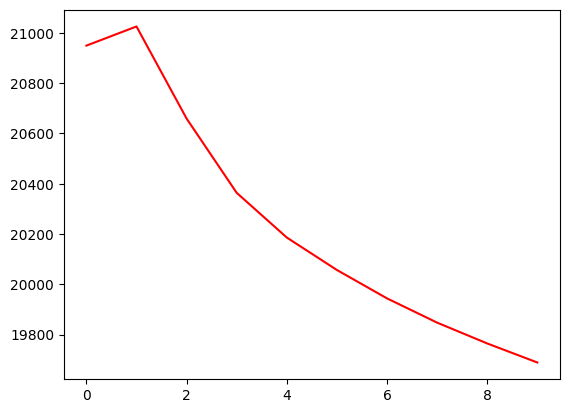

In [64]:
import matplotlib.pyplot as plt
plt.plot(np.array(loss_list),'r')

In [37]:
top1_list = []
top5_list = []
top10_list = []
ken_list = []
elapsed_time_list = []
for filename in filenames[:-1]:
    top1,top5,top10,ken,elapsed_time = test_file(filename,"./model_pth/best_model_10_old.pth")
    top1_list.append(top1)
    top5_list.append(top5)
    top10_list.append(top10)
    ken_list.append(ken)
    elapsed_time_list.append(elapsed_time)

# Calculate Mean for each evaluation metrics:
print()
print("Overall:")
print("Top-1% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top1_list)),np.std(np.array(top1_list))))
print("Top-5% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top5_list)),np.std(np.array(top5_list))))
print("Top-10% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top10_list)),np.std(np.array(top10_list))))
print("Kendall tau distance: {:.2f}±{:.2f}".format(np.mean(np.array(ken_list)),np.std(np.array(ken_list))))
print("Running time: {:.2f}±{:.2f}".format(np.mean(np.array(elapsed_time_list)),np.std(np.array(elapsed_time_list))))

Testing on 0.txt
Top-1% accuracy: 0.98
Top-5% accuracy: 0.88
Top-10% accuracy: 0.84
Kendall tau distance: 0.50
Elapsed time: 23.49 seconds
Testing on 1.txt
Top-1% accuracy: 0.92
Top-5% accuracy: 0.92
Top-10% accuracy: 0.85
Kendall tau distance: 0.50
Elapsed time: 22.75 seconds
Testing on 10.txt
Top-1% accuracy: 0.92
Top-5% accuracy: 0.89
Top-10% accuracy: 0.85
Kendall tau distance: 0.53
Elapsed time: 22.67 seconds
Testing on 11.txt
Top-1% accuracy: 0.96
Top-5% accuracy: 0.85
Top-10% accuracy: 0.83
Kendall tau distance: 0.53
Elapsed time: 22.81 seconds
Testing on 12.txt
Top-1% accuracy: 0.92
Top-5% accuracy: 0.85
Top-10% accuracy: 0.85
Kendall tau distance: 0.51
Elapsed time: 23.25 seconds
Testing on 13.txt
Top-1% accuracy: 0.90
Top-5% accuracy: 0.88
Top-10% accuracy: 0.83
Kendall tau distance: 0.52
Elapsed time: 22.89 seconds
Testing on 14.txt
Top-1% accuracy: 0.94
Top-5% accuracy: 0.84
Top-10% accuracy: 0.86
Kendall tau distance: 0.50
Elapsed time: 22.85 seconds
Testing on 15.txt
Top-

In [25]:
top1_list = []
top5_list = []
top10_list = []
ken_list = []
elapsed_time_list = []
for filename in filenames[:-1]:
    top1,top5,top10,ken,elapsed_time = test_file(filename,"./model_pth/best_model_10.pth")
    top1_list.append(top1)
    top5_list.append(top5)
    top10_list.append(top10)
    ken_list.append(ken)
    elapsed_time_list.append(elapsed_time)

# Calculate Mean for each evaluation metrics:
print()
print("Overall:")
print("Top-1% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top1_list)),np.std(np.array(top1_list))))
print("Top-5% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top5_list)),np.std(np.array(top5_list))))
print("Top-10% accuracy: {:.2f}±{:.2f}".format(np.mean(np.array(top10_list)),np.std(np.array(top10_list))))
print("Kendall tau distance: {:.2f}±{:.2f}".format(np.mean(np.array(ken_list)),np.std(np.array(ken_list))))
print("Running time: {:.2f}±{:.2f}".format(np.mean(np.array(elapsed_time_list)),np.std(np.array(elapsed_time_list))))

Testing on 0.txt
Top-1% accuracy: 0.98
Top-5% accuracy: 0.88
Top-10% accuracy: 0.83
Kendall tau distance: 0.42
Elapsed time: 25.76 seconds
Testing on 1.txt
Top-1% accuracy: 0.94
Top-5% accuracy: 0.91
Top-10% accuracy: 0.86
Kendall tau distance: 0.41
Elapsed time: 9.12 seconds
Testing on 10.txt
Top-1% accuracy: 0.94
Top-5% accuracy: 0.88
Top-10% accuracy: 0.85
Kendall tau distance: 0.42
Elapsed time: 8.47 seconds
Testing on 11.txt
Top-1% accuracy: 0.96
Top-5% accuracy: 0.85
Top-10% accuracy: 0.83
Kendall tau distance: 0.46
Elapsed time: 8.01 seconds
Testing on 12.txt
Top-1% accuracy: 0.92
Top-5% accuracy: 0.85
Top-10% accuracy: 0.85
Kendall tau distance: 0.42
Elapsed time: 8.47 seconds
Testing on 13.txt
Top-1% accuracy: 0.90
Top-5% accuracy: 0.88
Top-10% accuracy: 0.83
Kendall tau distance: 0.46
Elapsed time: 9.20 seconds
Testing on 14.txt
Top-1% accuracy: 0.94
Top-5% accuracy: 0.84
Top-10% accuracy: 0.86
Kendall tau distance: 0.44
Elapsed time: 8.96 seconds
Testing on 15.txt
Top-1% acc

In [ ]:
top1,top5,top10,ken,elapsed_time = test_file(filenames[-1],"./model_pth/best_model_10.pth")

Testing on com-youtube.txt
